# Segmenting and Clustering Localities in Mumbai For a Potential Residential Buyer

## Importing the necessary libraries

In [1]:

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis

import json # library to handle JSON files
import ipywidgets as widgets # library to display widgets
from ipywidgets import interact, interact_manual,Text, HTML
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML and XML documents

from pandas.io.json import json_normalize # transform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN 
from sklearn.neighbors import NearestNeighbors

import folium # map rendering library
from sklearn.preprocessing import StandardScaler
print("Libraries imported.")


Libraries imported.


## Importing data into a data frame
#### Source:  https://www.99acres.com/property-rates-and-price-trends-in-mumbai 
##### Note: For the sake of convenience and easy data cleaning, the data has been scrapped by simply copy pasting into an excel file and the data has been cleaned.

In [2]:
df=pd.read_excel("D:\\mumbai residential rates.xlsx")# The data has been stored into a dataframe from the excel file
df.head()

,Agashi,4378 - 4462,Mira Road And Beyond
0,Bhayander (East),7352 - 8160,Mira Road And Beyond
1,Bhayander (West),6842 - 8415,Mira Road And Beyond
2,Boisar,2932 - 3570,Mira Road And Beyond
3,Bolinj,4250 - 5142,Mira Road And Beyond
4,Chandan Shanti,8245 - 9308,Mira Road And Beyond


##### Note: For every locality, the price range (per sqft.) is provided.

## Data Wrangling

#### Assigning column names to the dataframe

In [3]:
df.columns=['Locality','Price per sqft(in Rupees)', 'Municipal Corporation'] 
df.head()

,Locality,Price per sqft(in Rupees),Municipal Corporation
0,Bhayander (East),7352 - 8160,Mira Road And Beyond
1,Bhayander (West),6842 - 8415,Mira Road And Beyond
2,Boisar,2932 - 3570,Mira Road And Beyond
3,Bolinj,4250 - 5142,Mira Road And Beyond
4,Chandan Shanti,8245 - 9308,Mira Road And Beyond


#### Convert "-" to NaN and removal of those values

In [4]:
print("Shape of the data before removing null values",df.shape)
df['Price per sqft(in Rupees)'].replace("-", np.nan, inplace = True)
df.dropna(axis=0, inplace= True) # to remove NA values

# resetting index because we dropped rows
df.reset_index(drop=True, inplace=True)
print("Shape of the data after removing null values",df.shape)

Shape of the data before removing null values (291, 3)
Shape of the data after removing null values (249, 3)


#### Splitting 'Price per sqft(in Rupees)' and finding the average Price per sqft(in Rupees)

In [5]:
df[['Min','Max']] = df['Price per sqft(in Rupees)'].str.split("-",expand=True) # Splitting the column price column into min and max price columns
df['Min']=df['Min'].astype('float')
df['Max']=df['Max'].astype('float')
df['Average Price per sqft(in Rupees)']=(df['Min']+df['Max'])/2
df.drop(columns=['Min','Max','Price per sqft(in Rupees)'],inplace= True)
df.tail() # displaying the last 5 rows

,Locality,Municipal Corporation,Average Price per sqft(in Rupees)
244,Sindhi Society Chembur,Mumbai Harbour,17999.0
245,Tilak Nagar,Mumbai Harbour,14046.0
246,Wadala,Mumbai Harbour,19274.0
247,Wadala East,Mumbai Harbour,19231.5
248,Wadala West,Mumbai Harbour,22503.5


#### Get the geographical coordinates

In [6]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
    # tomtom is a free to use geocoder api but an api key must be generated      
        g = geocoder.tomtom('{}, Mumbai, India'.format(neighborhood),key='cT9cxEoAQBQNDPuzOaAPIUSpJqSt0PXr') 
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [7]:
# call the function to get the coordinates, store in a new list using list comprehension
coords = [ get_latlng(neighborhood) for neighborhood in df["Locality"].tolist() ]


#### Merging coordinates with the main dataframe

In [8]:
# create temporary dataframe to populate the coordinates into Latitude and Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

# merge the coordinates into the original dataframe
df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']
df['Average Price per sqft(in Rupees)'] = df['Average Price per sqft(in Rupees)'].astype("int") # convert the column into integer type
df.head()

,Locality,Municipal Corporation,Average Price per sqft(in Rupees),Latitude,Longitude
0,Bhayander (East),Mira Road And Beyond,7756,19.29286,72.86142
1,Bhayander (West),Mira Road And Beyond,7628,19.29354,72.81804
2,Boisar,Mira Road And Beyond,3251,19.21532,72.86263
3,Bolinj,Mira Road And Beyond,4696,19.44152,72.87912
4,Chandan Shanti,Mira Road And Beyond,8776,19.29122,72.87379


## Widgets

#### In this particular widget, the user can choose the municipal corporation and choose the average price.
##### Note: Choosing a particular value for 'Average Price per sqft(in Rupees)' shows all the localities that have prices below the chosen value.

In [10]:
    filtered = pd.DataFrame()
    output = widgets.Output()

    dropdown_field = widgets.Dropdown(options = sorted(df['Municipal Corporation'].unique())) # To create a dropdown menu
    slider_price = widgets.IntSlider(value=5000, min=4000, max=60000,step=500) # To create a integer slider

    def common_filtering(field, price):
        global filtered
        output.clear_output()

        filtered = df[(df['Municipal Corporation']== field) & ( df['Average Price per sqft(in Rupees)']< price)]

        with output:
            display(filtered)

    def dropdown_field_eventhandler(change):
        common_filtering(slider_price.value,change.new)
    def slider_price_eventhandler(change):
        common_filtering(dropdown_field.value,change.new )

    dropdown_field.observe(dropdown_field_eventhandler, names='value')
    slider_price.observe( slider_price_eventhandler, names='value')

    input_widgets = widgets.HBox([dropdown_field,  slider_price])
    display(input_widgets)

    display(output)

Output()

#### Displaying the localities of Mumbai on a map

In [11]:
address = 'Mumbai, India'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Mumbai are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Mumbai are 18.9387711, 72.8353355.


In [12]:
# create map of Mumbai using latitude and longitude values
map_mumbai = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, municipal, neighborhood,price in zip(df['Latitude'], df['Longitude'], df['Municipal Corporation'], df['Locality'],df['Average Price per sqft(in Rupees)']):
    label = '<h4> {} </h4> <h5>Price per sqft:<b>Rs.{}</b></h5>'.format(neighborhood,price)# formatting the label
    label = folium.Popup(label, parse_html= False)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mumbai)  
    
map_mumbai

#### Setting up the Foursquare API to explore the localities

In [31]:
# define Foursquare Credentials and Version
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = 'L' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:L


### Function for getting top 10 nearby venues within 500m

In [14]:
LIMIT=10
radius=500
def getNearbyVenues(names, latitudes, longitudes,average):
    
    venues_list=[]
    for name, lat, lng,avg in zip(names, latitudes, longitudes,average):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat,
            lng,
            avg,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
                  'Locality',
                  'Locality Latitude',
                  'Locality Longitude',
                   'Average Price per sqft(in Rupees)',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
downtownt_venues = getNearbyVenues(names=df['Locality'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'],
                                   average=df['Average Price per sqft(in Rupees)']
                                  )

Bhayander (East)
Bhayander (West)
Boisar
Bolinj
Chandan Shanti
Chikhal Dongari
Ghodev
Gokul Township
Hatkesh Udhog Nagar
Juchandra
Kanakia Park
Kashigaon
Kashimira
Mira Bhayandar
Miragaon
Mira Road
Mira Road East
Naigaon (East)
Naigaon (West)
Nalasopara (West)
Nalasopara East
Nallasopara
Naya Nagar
Nilemore
Poonam Gardens
Poonam Sagar Complex
Ramdev Park
Shanti Nagar
Shanti Park
Sheetal Nagar
Sriprastha
Vasai
Vasai East
Vasai West
Vasant Nagari
Vijay Park
Virar
Virar East
Virar West
Y K Nagar
Aarey Milk Colony
Akurli Nagar
Alika Nagar
Amboli
Andheri (East)
Andheri (West)
Asha Nagar
Ashok Nagar Kandivali
Azad Nagar
Babhai
Bangur Nagar
Best Nagar
Bhagat Colony
Borivali (East)
Borivali (West)
Chakala
Charkop
Chikuwadi
Chincholi Bunder
Dahanukar Wadi
Dahisar
Dahisar (East)
Dahisar (West)
Dattapada
Daulat Nagar
Devipada
DN Nagar
Eksar
Ekta Nagar
Evershine Nagar
Gokuldham
Gorai
Gorai 2
Goregaon (East)
Goregaon (West)
Govind Nagar
Hemu Colony
I C Colony
Irani Wadi
Jankalyan Nagar
Jawahar Naga

In [16]:
downtownt_venues.tail()

,Locality,Locality Latitude,Locality Longitude,Average Price per sqft(in Rupees),Venue,Venue Latitude,Venue Longitude,Venue Category
1689,Wadala East,19.01894,72.85826,19231,cafe coffee day,19.017676,72.855814,Café
1690,Wadala East,19.01894,72.85826,19231,Chandu Halvai,19.018986,72.860147,Fast Food Restaurant
1691,Wadala East,19.01894,72.85826,19231,relax fast food,19.022382,72.857583,Fast Food Restaurant
1692,Wadala West,19.02508,72.88899,22503,"BPCL Sports Complex, Chembur",19.022638,72.889690,Playground
1693,Wadala West,19.02508,72.88899,22503,Mysore Colony Monorail Station,19.027771,72.891109,Train Station


#### Finding the number of unique categories of venues in Mumbai

In [17]:
print('There are {} uniques categories.'.format(len(downtownt_venues['Venue Category'].unique())))

There are 195 uniques categories.


##### One Hot Encoding

In [18]:
# one hot encoding
t_onehot = pd.get_dummies(downtownt_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe

t_onehot['Locality'] = downtownt_venues['Locality'] 

# move neighborhood column to the first column
fixed_columns = [t_onehot.columns[-1]] + list(t_onehot.columns[:-1])
t_onehot = t_onehot[fixed_columns]

t_onehot.head()

,Locality,ATM,Accessories Store,Airport,Airport Lounge,Airport Terminal,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,...,Track,Trail,Train,Train Station,Vegetarian / Vegan Restaurant,Waterfront,Wine Bar,Women's Store,Yoga Studio,Zoo
0,Bhayander (East),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bhayander (East),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bhayander (East),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bhayander (East),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bhayander (East),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
t_grouped = t_onehot.groupby('Locality').mean().reset_index()
t_grouped.head()

,Locality,ATM,Accessories Store,Airport,Airport Lounge,Airport Terminal,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,...,Track,Trail,Train,Train Station,Vegetarian / Vegan Restaurant,Waterfront,Wine Bar,Women's Store,Yoga Studio,Zoo
0,Aarey Milk Colony,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,Agripada,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.1
2,Akurli Nagar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0
3,Alika Nagar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,Altamount Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


#### Displaying localities with their 10 most common type of venues

In [20]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Locality']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Locality'] = t_grouped['Locality']

for ind in np.arange(t_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(t_grouped.iloc[ind, :], num_top_venues)


neighborhoods_venues_sorted.head()

,Locality,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aarey Milk Colony,Playground,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farm,Falafel Restaurant,Entertainment Service,Electronics Store,Donut Shop,Diner
1,Agripada,Indian Restaurant,Zoo,Asian Restaurant,Bar,Bakery,Pharmacy,History Museum,Gourmet Shop,Dessert Shop,Fish & Chips Shop
2,Akurli Nagar,Indian Restaurant,Fast Food Restaurant,Train Station,Dessert Shop,Café,Snack Place,Coworking Space,Cricket Ground,Fish & Chips Shop,Convenience Store
3,Alika Nagar,Dessert Shop,Plaza,Miscellaneous Shop,Bakery,Soccer Field,Coffee Shop,Diner,Fish & Chips Shop,Fast Food Restaurant,Farm
4,Altamount Road,Bookstore,Indian Restaurant,Brewery,Café,Restaurant,Bar,Bakery,Theater,Pizza Place,Coffee Shop


## K-Means Clustering

In [21]:
t_g=t_grouped.merge(df,on='Locality',how='inner')
t_g.drop_duplicates(['Locality'],inplace=True)
t_g.drop(['Municipal Corporation','Locality'],axis=1,inplace=True)
X = t_g.values[:,1:]
#Clus_dataSet = StandardScaler().fit_transform(X)
#Clus_dataSet

#### Elbow method for determining the optimal k value

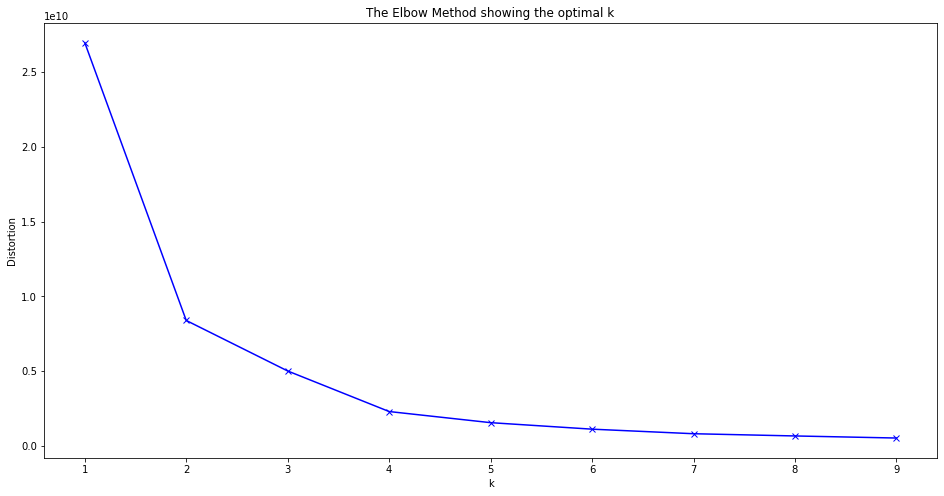

In [22]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [23]:
# set number of clusters
kclusters = 4
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)
# add clustering labels
neighborhoods_venues_sorted['Cluster Labels']=kmeans.labels_+1
neighborhoods_venues_sorted.head()


,Locality,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Aarey Milk Colony,Playground,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farm,Falafel Restaurant,Entertainment Service,Electronics Store,Donut Shop,Diner,4
1,Agripada,Indian Restaurant,Zoo,Asian Restaurant,Bar,Bakery,Pharmacy,History Museum,Gourmet Shop,Dessert Shop,Fish & Chips Shop,3
2,Akurli Nagar,Indian Restaurant,Fast Food Restaurant,Train Station,Dessert Shop,Café,Snack Place,Coworking Space,Cricket Ground,Fish & Chips Shop,Convenience Store,2
3,Alika Nagar,Dessert Shop,Plaza,Miscellaneous Shop,Bakery,Soccer Field,Coffee Shop,Diner,Fish & Chips Shop,Fast Food Restaurant,Farm,2
4,Altamount Road,Bookstore,Indian Restaurant,Brewery,Café,Restaurant,Bar,Bakery,Theater,Pizza Place,Coffee Shop,1


In [24]:
t_merged = df.merge(neighborhoods_venues_sorted, on='Locality', how='right')
t_merged.head()

,Locality,Municipal Corporation,Average Price per sqft(in Rupees),Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Aarey Milk Colony,Mumbai Andheri-Dahisar,8117,19.13706,72.88306,Playground,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farm,Falafel Restaurant,Entertainment Service,Electronics Store,Donut Shop,Diner,4
1,Agripada,Mumbai South,27667,18.97779,72.83190,Indian Restaurant,Zoo,Asian Restaurant,Bar,Bakery,Pharmacy,History Museum,Gourmet Shop,Dessert Shop,Fish & Chips Shop,3
2,Akurli Nagar,Mumbai Andheri-Dahisar,18360,19.20257,72.85332,Indian Restaurant,Fast Food Restaurant,Train Station,Dessert Shop,Café,Snack Place,Coworking Space,Cricket Ground,Fish & Chips Shop,Convenience Store,2
3,Alika Nagar,Mumbai Andheri-Dahisar,15364,19.19886,72.87698,Dessert Shop,Plaza,Miscellaneous Shop,Bakery,Soccer Field,Coffee Shop,Diner,Fish & Chips Shop,Fast Food Restaurant,Farm,2
4,Altamount Road,Mumbai South,61774,18.96735,72.80956,Bookstore,Indian Restaurant,Brewery,Café,Restaurant,Bar,Bakery,Theater,Pizza Place,Coffee Shop,1


## Examining Clusters
#### We will be first seeing the bar graphs of the most common venues in each of the clusters.

### Cluster 1

Average Price per sqft(in Rupees)): 43338


(22, 10)

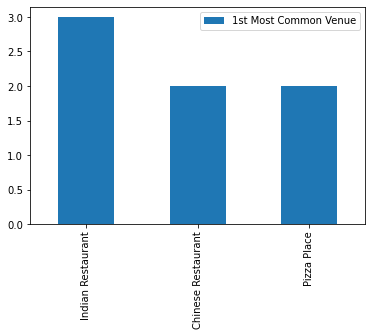

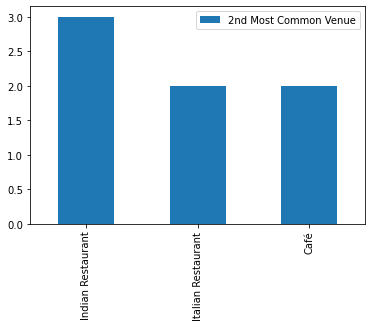

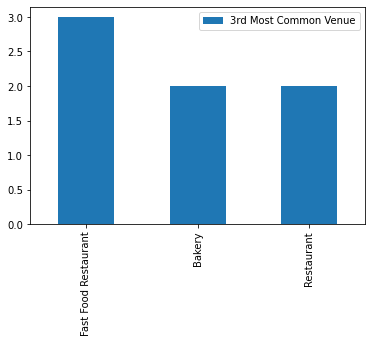

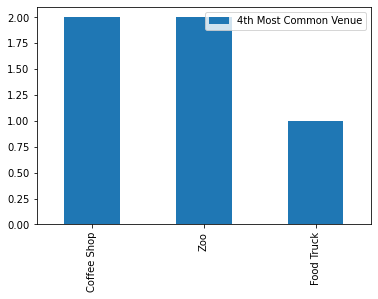

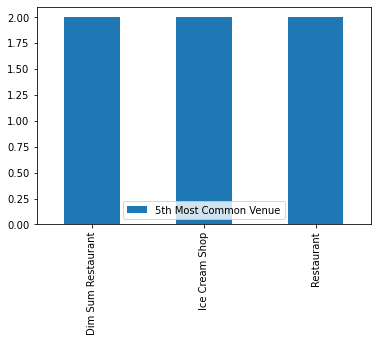

In [25]:
cluster1=neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels']==1]

print('Average Price per sqft(in Rupees)): 43338')
c1=cluster1.drop(["Locality","Cluster Labels"],1).reset_index()
c1.drop('index',1,inplace= True)
i=0
for i in range(5):
    c=pd.DataFrame(c1.iloc[:,i].value_counts())
    c[0:3].plot.bar()
c1.shape

### Cluster 2

Average Price per sqft(in Rupees)): 15988


(138, 10)

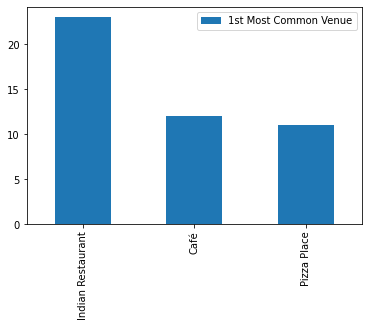

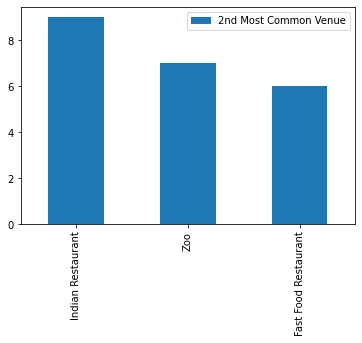

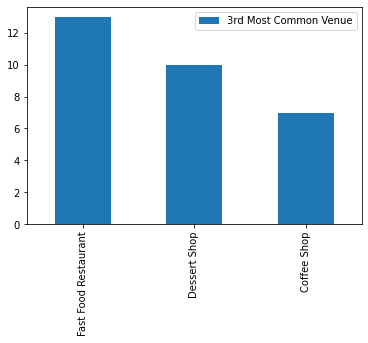

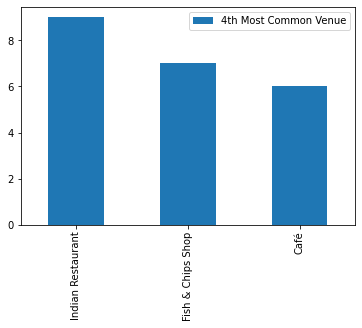

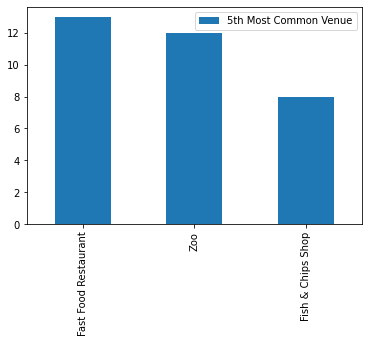

In [26]:
cluster1=neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels']==2]
print('Average Price per sqft(in Rupees)): 15988')
c1=cluster1.drop(["Locality","Cluster Labels"],1).reset_index()
c1.drop('index',1,inplace= True)
i=0
for i in range(5):
    c=pd.DataFrame(c1.iloc[:,i].value_counts())
    c[0:3].plot.bar()
c1.shape

### Cluster 3

Average Price per sqft(in Rupees)): 28064


(44, 10)

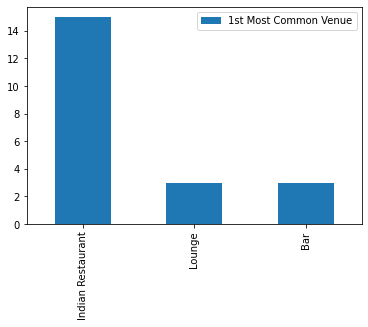

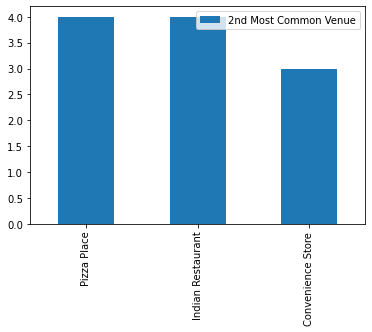

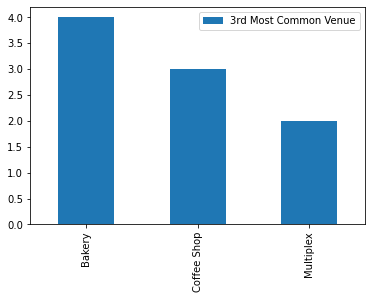

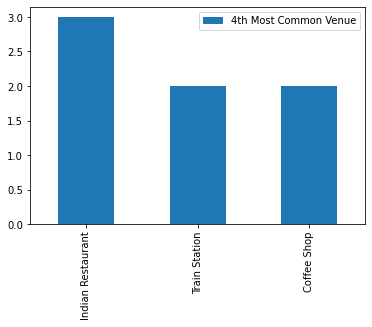

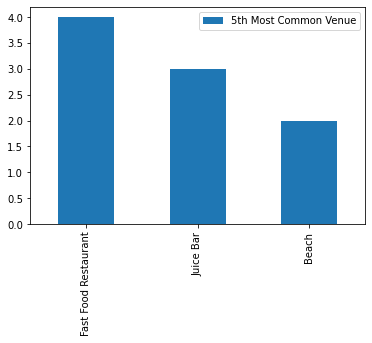

In [27]:
cluster1=neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels']==3]
print('Average Price per sqft(in Rupees)): 28064')
c1=cluster1.drop(["Locality","Cluster Labels"],1).reset_index()
c1.drop('index',1,inplace= True)
i=0
for i in range(5):
    c=pd.DataFrame(c1.iloc[:,i].value_counts())
    c[0:3].plot.bar()
c1.shape

### Cluster 4

Average Price per sqft(in Rupees)): 6430


(41, 10)

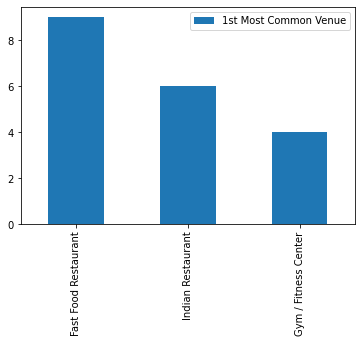

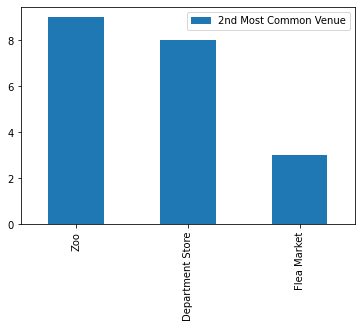

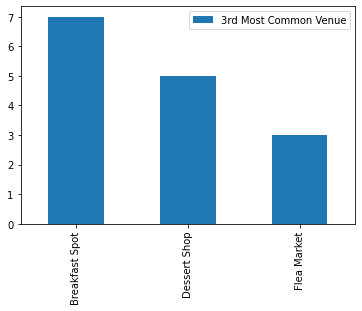

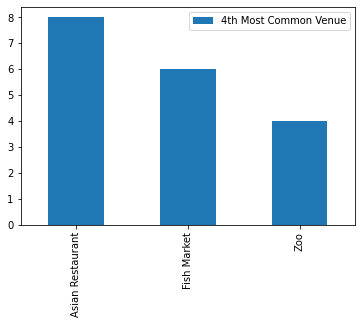

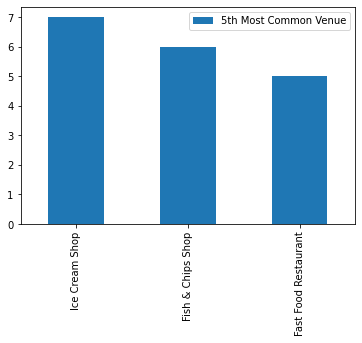

In [28]:
cluster1=neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels']==4]
print('Average Price per sqft(in Rupees)): 6430')
c1=cluster1.drop(["Locality","Cluster Labels"],1).reset_index()
c1.drop('index',1,inplace= True)
i=0
for i in range(5):
    c=pd.DataFrame(c1.iloc[:,i].value_counts())
    c[0:3].plot.bar()
c1.shape

## Cluster Map

In [29]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = ['red', 'blue', 'green', 'orange']

# add markers to the map
print('Clusters:\n Cluster 1: \t Red \n Cluster 2: \t Blue \n Cluster 3: \t Green \n Cluster 4: \t Orange')
markers_colors = []
for lat, lon, poi, cluster, avg, one, two, three in zip(t_merged['Latitude'], t_merged['Longitude'], t_merged['Locality'], t_merged['Cluster Labels'], t_merged['Average Price per sqft(in Rupees)'],t_merged['1st Most Common Venue'],t_merged['2nd Most Common Venue'],t_merged['3rd Most Common Venue']):
   # label = folium.Popup(str(poi) + ' Cluster ' + str(cluster)+' Rs.'+str(avg), parse_html=False)
    label = '<b><h4> {} </h4><h4><h5><b> Cluster {} </b></h5><h5>Price per sqft:</h5><h4><b>Rs.{}</b></h4><h5>Most common venues:</h5><b><ol><li>{}</li><li>{}</li><li>{}</li></ol></b>'.format(poi,cluster,avg,one, two, three)# formatting the label
    label = folium.Popup(label, parse_html= False)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Clusters:
 Cluster 1: 	 Red 
 Cluster 2: 	 Blue 
 Cluster 3: 	 Green 
 Cluster 4: 	 Orange


## Widgets
#### In this particular widget, the user can choose the cluster and choose the price.
##### Note: Choosing a particular value for 'Average Price per sqft(in Rupees)' shows all the localities that have prices below the chosen value.

In [30]:
    print(t_merged.groupby('Cluster Labels').mean())
    t_merged['Cluster Labels']=t_merged['Cluster Labels'].astype('str')
    filtered = pd.DataFrame()
    output = widgets.Output()

    dropdown_field = widgets.Dropdown(options = sorted(t_merged['Cluster Labels'].unique())) # To create a dropdown menu
    dropdown_wellname = widgets.IntSlider(value=5000, min=4000, max=60000) # To create a integer slider

    def common_filtering(field, wellname):
        global filtered
        output.clear_output()

        filtered = t_merged[(t_merged['Cluster Labels']== field) & ( t_merged['Average Price per sqft(in Rupees)']<wellname)]

        with output:
            display(filtered)

    def dropdown_field_eventhandler(change):
        common_filtering(dropdown_wellname.value,change.new)
    def dropdown_wellname_eventhandler(change):
        common_filtering(dropdown_field.value,change.new )

    dropdown_field.observe(dropdown_field_eventhandler, names='value')
    dropdown_wellname.observe(dropdown_wellname_eventhandler, names='value')

    input_widgets = widgets.HBox([dropdown_field, dropdown_wellname])
    display(input_widgets)

    display(output)

                Average Price per sqft(in Rupees)   Latitude  Longitude
Cluster Labels                                                         
1                                    43589.363636  18.993906  72.822801
2                                    15959.492857  19.138249  72.871993
3                                    28158.511111  19.038612  72.839656
4                                     6433.390244  19.194879  72.857094


Output()